# InVivo Technical Test

This is a short report of an analysis conducted on the supplied data set. It was done with no prior knowledge of chemistry or RDKit. Since this was done in a relatively short time span (one weekend, since I work full time), I aimed to put forth my interpretation of the results rather than producing the best results possible. Better results could be achieved by further tunning the model parameters. 

The report is divided into four sections:
- Preliminary Data Analysis
- Building Classifiers
- Results
- Conclusion

To run this notebook please ensure the following libraries are installed:

conda install -c statiskit libboost_python

conda install -c rdkit rdkit

conda install -c conda-forge matplotlib

conda install -c anaconda pandas

conda install -c pytorch pytorch

conda install -c pytorch torchvision

conda install -c conda-forge jupyter_contrib_nbextensions # For code folding in report

*Extra: Since I am learning PyTorch, I provided code for running a pretrained network on Target 1. Code is commented in Appendix A.*

In [137]:
from __future__ import print_function, division

## Generic imports
import numpy as np
import pandas as pd
import os
import io
import copy
import time
import importlib
import pickle
from pprint import pprint

##ML imports
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## NN imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

## Mol imports
from rdkit import Chem
from rdkit.Chem import PandasTools 
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint, GetMorganFingerprintAsBitVect
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps

#Local imports
import helpers

# Preliminary Data Analysis and PreProcessing

Data was loaded following which a TSNE embedding was performed in order to gain an understanding of the data. A similarity analysis was run between targets. Finally, a short manual assessment of molecular substructures relevant for targets 1 and 2 was attempted.

## Preprocessing

,smiles,molecule,target1,target2,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12,fingerprint,molID
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,,0.00,0.00,1.00,nan,nan,0.00,0.00,1.00,0.00,0.00,0.00,0.00,,mol-0
1,CCN1C(=O)NC(c2ccccc2)C1=O,,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,,mol-1
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]3CC[C@@]21C,,nan,nan,nan,nan,nan,nan,nan,0.00,nan,0.00,nan,nan,,mol-2
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,0.00,nan,0.00,0.00,,mol-3
4,CC(O)(P(=O)(O)O)P(=O)(O)O,,0.00,0.00,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,0.00,,mol-4

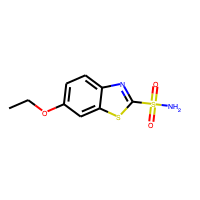
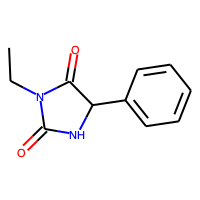
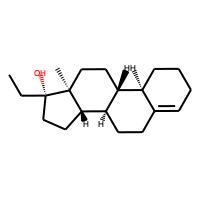
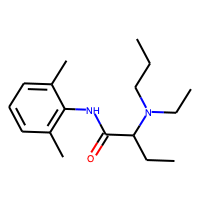
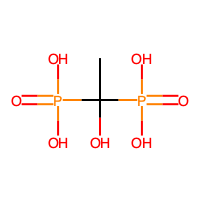

In [224]:
img_data_dir = 'molImages'
fingerprint_length = 2048

dataSet = pd.read_csv("data.csv")
PandasTools.AddMoleculeColumnToFrame(dataSet,'smiles','molecule',includeFingerprints=True)
columns = dataSet.columns.tolist()
columns = [columns[0]] + columns[-1:] + columns[1:-1]
dataSet = dataSet[columns]
dataSet = dataSet.assign(fingerprint=pd.Series([GetMorganFingerprint(x, 2) for x in dataSet['molecule']]))
dataSet = dataSet.assign(molID=pd.Series(['mol-{0}'.format(count) for count, x in enumerate(dataSet['molecule'])]))
dataSet.head()


In [123]:
trainSuperSet = dataSet.sample(frac=0.75, random_state=42)
validationSuperSet = dataSet.drop(trainSuperSet.index)

class_splits = {}

for i in range(1,13):
    trainSet = trainSuperSet['target{0}'.format(i)]
    validSet = validationSuperSet['target{0}'.format(i)]
    target = 'target{0}'.format(i)
    class_splits[i] = {
        'trainCount': [np.count_nonzero(trainSet==0),np.count_nonzero(trainSet==1),np.count_nonzero(~np.isnan(trainSet))],
        'validCount': [np.count_nonzero(validSet==0),np.count_nonzero(validSet==1),np.count_nonzero(~np.isnan(validSet))],
        'train': trainSuperSet[~np.isnan(trainSuperSet[target])],
        'valid': validationSuperSet[~np.isnan(validationSuperSet[target])] 
    }


## Quick analysis of class distribution

All molecules were succesfully loaded into RDKit.

As shown by the table below, positive targets are rare events. For all targets, classes (positive, negative) are highly skewed towards negative. This will be taken into consideration in our approach.

NOTE: Missing values were disregarded for all subsequent analyses. This is why counts will not add up to the total number of molecules. This was done to simplify the analysis given the timeframe. We also assume there that the labels provided (0 and 1) are correct.

In [71]:
dataSet.columns[2:-2]
dataSet[dataSet.columns[2:-2]].apply(pd.value_counts)

,target1,target2,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12
0.00,7129,6664,5906,5633,5518,6756,6394,4974,6965,6215,4984,6478
1.00,310,238,785,307,798,356,189,961,267,379,936,431


## Interpretation of TSNE
TSNE produce a probabilistic embedding of data in a lower dimensional space by trying to conserve the distances between datapoints. I embedded the data in 2D space with to goal of gaining a qualitative assessment of the Morgan fingerprint. The top graph shows the scatter plot of all molecules. We see a dense oval scatter which indicates that the molecules may be distributed fairly evenly over the fingerprint space. The following 12 plots show only the positive examples for each of the targets. We note a few key observations:

* In targets 1,2,5 and 6, there is a distinct cluster in the upper right corner of the embedding. This suggests there may be a correlation between certain targets. 
* All targets seem to have molecules dispersed over the whole embedding. This suggests that the presence of a target on a molecule may be due to a small configuration of atoms on the molecule. Which would mean that molecules can be different overall but still exhibit the same target behaviour. The clusters observed could also indicate that certain configurations are more present in small molecules or molecules that share other similarities. 



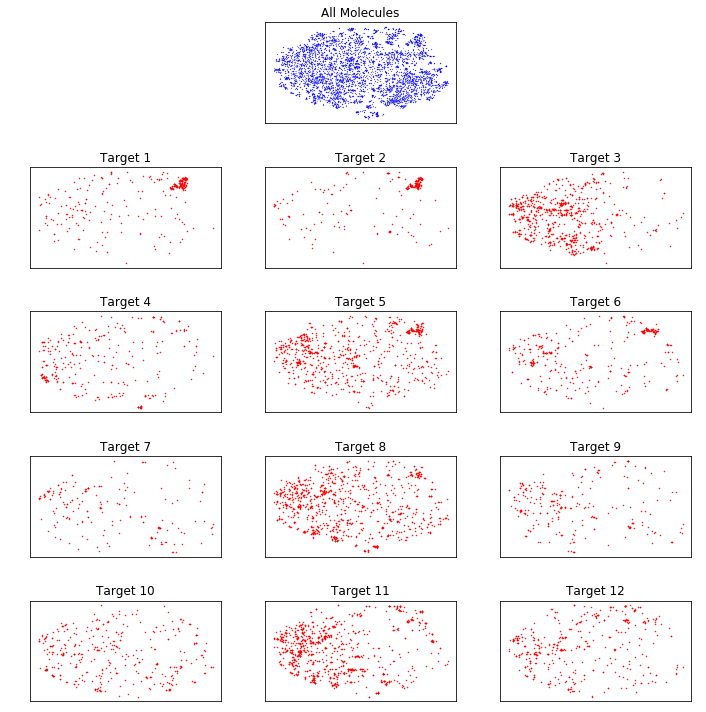

In [86]:
## Uncomment to run TSNE. Leave commented to load pre-computed TSNE
# Running TSNE takes a bit more than 30 minutes on a MacBook Pro 2016, 
# 2.4 GHz Intel Core i7, 16 GB 1867 MHz LPDDR3
# # from https://www.rdkit.org/docs/GettingStartedInPython.html
# def distij(i,j,fps=dataSet['fingerprint']):
#    return 1-DataStructs.DiceSimilarity(fps[int(i)],fps[int(j)])
# X = np.arange(len(dataSet['molecule'])).reshape((-1,1))
# start = time.time()
# X_embedded = TSNE(n_components=2, metric=distij).fit_transform(X)
# stop = time.time()
# pprint('elapsed: {0}'.format(stop - start))
# np.save('tsne_embeding.npy', X_embedded)
tsne_embedding = np.load('tsne_embeding.npy')
importlib.reload(helpers)
helpers.plot_TSNE(tsne_embedding, dataSet)

## Correlation between different targets
Our first observation with TSNE was that some target seems to have some sort of correlation, in other words, if we observe that a molecule has Target 1, it is more likely to also have target 2 than any other randomly chosen molecule. To validate this assumption a similarity metric between target occurences was computed. Since the data is strongly imbalanced, the metric was chosen to only consider positive instances. It is computed by summing the joint occurences of two targets and dividing by the sum of the occurences of these same targets. A factor of 2 is added so that the metric lies between 0 and 1.

$\frac{2 \cdot \sum{target_i \;\&\&\; target_j}}{\sum{target_i} + \sum{target_j}}$

Values above 0.2 are highlighted in yellow, while 0.5 are highlighted in green. We see that the first observation from TSNE holds. The following targets seemed prone to pairing :  1 and 2, 5 and 6 and 8 and 11.

In [87]:
simmilarityMatrix = pd.DataFrame(helpers.computeCustomSimilarityMatrix(dataSet))
simmilarityMatrix.rename(columns= lambda x: 'target {0}'.format(int(x)+1),
                         index= lambda x: 'target {0}'.format(int(x)+1),
                         inplace=True)
pd.options.display.float_format = '{:,.2f}'.format
def highlight_20(s):
    low = s >= 0.20
    return ['background-color: yellow' if v else '' for v in low]
def highlight_50(s):
    low = s >= 0.50
    return ['background-color: green' if v else '' for v in low]

simmilarityMatrix.style.apply(highlight_20).apply(highlight_50)

,target 1,target 2,target 3,target 4,target 5,target 6,target 7,target 8,target 9,target 10,target 11,target 12
target 1,1,0.579151,0.073501,0.0589569,0.245446,0.231746,0.0215983,0.101664,0.0943739,0.021164,0.0815265,0.0702247
target 2,0.579151,1,0.0538642,0.135385,0.214602,0.336714,0.235669,0.132558,0.214112,0.162025,0.12761,0.26501
target 3,0.073501,0.0538642,1,0.23845,0.31021,0.14739,0.0756193,0.382555,0.256085,0.168285,0.423584,0.220039
target 4,0.0589569,0.135385,0.23845,1,0.116904,0.167064,0.0948905,0.286131,0.112583,0.230769,0.350299,0.279898
target 5,0.245446,0.214602,0.31021,0.116904,1,0.518,0.0560976,0.281442,0.228089,0.116364,0.346154,0.163009
target 6,0.231746,0.336714,0.14739,0.167064,0.518,1,0.168224,0.215447,0.25,0.226415,0.284884,0.255462
target 7,0.0215983,0.235669,0.0756193,0.0948905,0.0560976,0.168224,1,0.175532,0.263158,0.301136,0.171108,0.344633
target 8,0.101664,0.132558,0.382555,0.286131,0.281442,0.215447,0.175532,1,0.218145,0.27177,0.512053,0.330138
target 9,0.0943739,0.214112,0.256085,0.112583,0.228089,0.25,0.263158,0.218145,1,0.209677,0.195833,0.34375
target 10,0.021164,0.162025,0.168285,0.230769,0.116364,0.226415,0.301136,0.27177,0.209677,1,0.29366,0.406716


## Manually Identifying Molecule Patterns for Target 1 and 2
Target 1 and 2 seem to present high density in the TSNE embedding. This suggest that for these targets all molecules may be both similar and of similar size. For this reason, a visual analysis was done on a random subsample of each target. This is only an indicative qualitative assessment. 

For Target 1, a visual assessment of 10 molecules suggests that the presence of a lone Oxygen atom bound to the molecule could be an indicator of target one.

Unfortunately, for target 2 this analysis was not sufficient to identify a candidate pattern. 

This analysis was not pushed further, but could yield interesting results with a bit more expert knowledge and a better understanding of what a fingerprint is.

To see the plotted similarites uncomment the code below. This may suggest that observation 2: That molecule substructures are at the origin of target expression could be false, at least for target 2. (Sorry for the formatting. Couldn't find a nice way to display them in a grid with RDKit.)

This code is highly inspired by : https://www.rdkit.org/docs/GettingStartedInPython.html

In [201]:
# # Target 1
# def generateFig(refmol, mol):
#     fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=1, fpType='count'), metric=DataStructs.DiceSimilarity, size=(75, 75))
#     return fig
# visualSimilarityDf = dataSet.loc[dataSet['target1'] == 1].sample(frac=0.1, random_state=42)['smiles'][0:10]

# smiles = list(visualSimilarityDf)
# refmol = Chem.MolFromSmiles(smiles[0])
# figures = []
# mol = Chem.MolFromSmiles(smiles[1])
# figures = [generateFig(refmol,Chem.MolFromSmiles(m)) for m in smiles]

In [121]:
# # Target 2
# def generateFig(refmol, mol):
#     fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=1, fpType='count'), metric=DataStructs.DiceSimilarity, size=(75, 75))
#     return fig
# visualSimilarityDf = dataSet.loc[dataSet['target2'] == 1].sample(frac=0.1, random_state=42)['smiles'][0:10]

# smiles = list(visualSimilarityDf)
# refmol = Chem.MolFromSmiles(smiles[0])
# figures = []
# mol = Chem.MolFromSmiles(smiles[1])
# figures = [generateFig(refmol,Chem.MolFromSmiles(m)) for m in smiles]

# Building Classifiers

This section concentrates on building classifiers to analyse the data. Due to the highly imbalanced nature of the dataset, ensemble methods were prefered. Fingerprints written as binary vectors share a similarity with the bag of word approach in natural language processing. For this reason, logistic regression was chosen as a baseline. 

The fingerprint length was used as a hyper-parameter we tested lengths of: 256, 512, 1024, 2048, and 4096.

A very limited gridsearch was run on the different models to tune each models parameters, in order to keep the training time reasonable. The parameters tested are as follow:

For logistic regression (LR): 
    - C: [0.001,0.01,0.1,1]
For random tree forest (RTF):
    - number of estimators: [100,400]
    - max depth: [10,80]
For adaboost (ADA):
    - estimator: tree stub
    - number of estimators: [100,400]
    - learning rate: [0.001,0.1]

3-fold cross-validation was used to training and testing. 

F1 measure is reported instead of accuracy and was used to select the best models. The imbalance in the dataSets leads to a all-in-one classification accuracy of more than 90%. For more specific results, the models could be trained to minimize different metrics (e.g. reduce false positive rate, reduce false negative rate, ...). Since the goal was not specified, the F1 measure was used as it combines precision and accuracy.
Three fold CV was used to compute train and test error. 
A hold out test set, validation set, was used to compare the different models. The validation error was computed after training the best model at CV on all of the train/test data, and then predicting the labels of the validation set.


In [195]:
results = {
    'lr': {},
    'rtf': {},
    'ada': {}
}
verbose = True
all_lengths = [256, 512, 1024, 2048, 4096]
for t in range(1,13):
    results['lr'][t] = []
    results['rtf'][t] = []
    results['ada'][t] = []
for fp_length in all_lengths:
    print('training models for length {0}'.format(fp_length))
    for t in range(1,13):
        if verbose : print('  training target {0}'.format(t))
        X = np.array([list(GetMorganFingerprintAsBitVect(x, 2, nBits = fp_length)) for x in list(class_splits[t]['train']['molecule'])])
        y = np.array(list(class_splits[t]['train']['target{0}'.format(t)]))

        X_valid = np.array([list(GetMorganFingerprintAsBitVect(x, 2, nBits = fp_length)) for x in list(class_splits[t]['valid']['molecule'])])
        y_valid = np.array(list(class_splits[t]['valid']['target{0}'.format(t)]))
        
        ## Logistic Regression Baseline
        if verbose : print('    lr...')
        results['lr'][t].append(helpers.train_LR(X, y, X_valid, y_valid))
        
        ## Random Tree Forest
        if verbose : print('    rtf...')
        results['rtf'][t].append(helpers.train_RTF(X, y, X_valid, y_valid))
        
        ## Adaboost (ADA BOOST IS SLOW UNCOMMENT only if necessary)
        #if verbose : print('    ada...')
        #results['ada'][t].append(helpers.train_ADA(X, y, X_valid, y_valid))
        
#pickle.dump(results, open( "model_results.p", "wb" ))

training models for length 256
training models for length 512
training models for length 1024
training models for length 2048
training models for length 4096


In [ ]:
results = pickle.load( open( "model_results.p", "rb" ) )

# Results

The table below shows the train, test and validation scores on the targets for the different algorithms. The best score for each column is highlighted in yellow. The parameter search was very limited. For this reason, overfitting is observed with the RTF model on all targets, and very poor performance for the ADA Boost model on all but targets 1 and 2. 

Logistic Regression performed best over all. The optimal parameters for the logistic regression model given the restricted search space were:
- C = 1
- FP Length = 4096

## F1 scores

In [227]:
# results = pickle.load( open( "model_results.p", "rb" ) )
resultsDF = helpers.format_results_table(results)
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

resultsDF.style.apply(highlight_max)
#resultsDF.to_latex()

## Confusion Matrices for Target 1 and FP Length = 4096

The following confusion matrices show the importance of looking at other measures that accuracy for success. While the accuracy would be close to or over 95% for all models, the actual percentage of positive targets identified is near 50%. The more complex models are able to maintain a similar rate of True Positives and False Negatives while lowering the rate of False Positives. On Target 1 with FP Length of 4096, ADABoost shows a very low False Positive Rate on validation. 

In [230]:
importlib.reload(helpers)
helpers.print_CMs(results,1,4)

LR:
        pred:0  pred:1
true:0    1708      63
true:1      39      40

RTF:
        pred:0  pred:1
true:0    1760      11
true:1      41      38

ADA:
        pred:0  pred:1
true:0    1768       3
true:1      45      34


## Influence of the Fingerprint Length Hyper-Parameter on Target 1

The fingerprint length had little influence on the RTF model for Target 1, which also indicates some overfitting. 
ADABoost and Logistic Regression both benefit from a longer fingerprint.

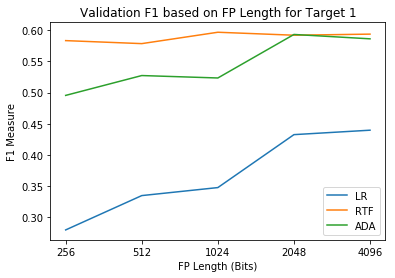

In [222]:
lengths = ["256", "512", "1024", "2048", "4096"]
plt.plot( lengths , resultsDF['target1']['valid'].iloc[0:5].values)
plt.plot( lengths , resultsDF['target1']['valid'].iloc[5:10].values)
plt.plot( lengths , resultsDF['target1']['valid'].iloc[10:15].values)
plt.title("Validation F1 based on FP Length for Target 1")
plt.xlabel("FP Length (Bits)")
plt.ylabel("F1 Measure")
plt.legend(['LR', 'RTF','ADA'])
plt.show()

# Conclusion

While Logistic Regression performed best overall, results on Targets 1 and 2 suggest that, given more time for parameter tunning, ADABoost may perform best. It would be interesting to see what caused its performance to plummet for targets 3 to 12. This conclusion is based both on the observation of confusion matrices and the f1 scores outlined above. 

Overall, fingerprint representations seem to the main limitations of the approach outlined above. We observed this through the TSNE embedding and the effect of the fingerprint length. Many types of fingerprints exist in litterature and in RDKit and it would be interesting to compare these different fingerprints. 

All fingerprints are sets of expertly engineered features. Deep learning approaches, as outlined in Appendix A, could prove interesting with the caveat that 2D representations are not actual images of molecules. This implies a certain feature extraction at the representation level. 

# Appendix A
The following section contains code for using a pretrained neural-net to build classifier for the different targets. 

I didn't have time to tune this approach since running 25 epochs for 1 target on my current configuration takes >4 hours. Feel free to run the code if you'd like but the parameters are not optimized. You will also need to generate the images. 

## Using a pretrained Neural Network
Following the assumption that specific molecule substructures explain target labels, it is interesting to see if neural network pretrained on ImageNet can be used to classify the targets. In the weights of the network were not tunned. Only the final classifier was retrained. 

Class weights were used for the cross-entropy loss in order to deal with the class imbalance.

In [ ]:
## Uncomment to generate the file structure and data for the Neural-Net transfer learning model.   
#for i in range(1,13): 
    #     helpers.generateMolClassifiedImages(trainSuperSet['molecule'],
    #                                         trainSuperSet[target],
    #                                         trainSuperSet['molID'],
    #                                         folder=os.path.join(img_data_dir,'train', target))
    #     helpers.generateMolClassifiedImages(validationSuperSet['molecule'],
    #                                         validationSuperSet[target],
    #                                         validationSuperSet['molID'],
    #                                         folder=os.path.join(img_data_dir,'val', target))

In [160]:
######
# The following code is highly inspired from the pytorch tutorial.
# I am currently learning how to use pytorch and wanted to make use of it in this
# exercise
# Source: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# License: BSD
# Author: Sasank Chilamkurthy
######

# # Apply data transforms
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# image_datasets = {'target{0}'.format(t): {'train': datasets.ImageFolder(os.path.join(img_data_dir, 'train/target{0}'.format(t)),
#                                               data_transforms['train']),
#                       'val': datasets.ImageFolder(os.path.join(img_data_dir, 'val/target{0}'.format(t)),
#                                               data_transforms['val'])}
#                 for t in range(1,13)}


In [176]:
# # Determine weights and load data for target 1
# weights = helpers.computeWeightsForTarget(class_splits, 1) 
# tensorTrainWeights = torch.tensor(weights['train'])
# samplers = {
#     'train': torch.utils.data.sampler.BatchSampler(torch.utils.data.sampler.WeightedRandomSampler(weights['train'], 2),100, True),
#     'val': torch.utils.data.sampler.BatchSampler(torch.utils.data.sampler.WeightedRandomSampler(weights['val'], 2),20, True)
# }

# dataloaders = {x: torch.utils.data.DataLoader(image_datasets['target1'][x],
#                                               num_workers=4, shuffle=True, batch_size=100) #batch_sampler=samplers[x])
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets['target1'][x]) for x in ['train', 'val']}
# class_names = image_datasets['target1']['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [178]:
# # Set up the model fro training
# model_conv = torchvision.models.resnet18(pretrained=True)
# for param in model_conv.parameters():
#     param.requires_grad = False

# # Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 2)

# model_conv = model_conv.to(device)

# criterion = nn.CrossEntropyLoss(weight=tensorTrainWeights)

# # Observe that only parameters of final layer are being optimized as
# # opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.005, momentum=0.9)

# # Decay LR by a factor of 0.1 every 10 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.1)


In [231]:
# # Train the model
# model_conv, scores = helpers.train_model(dataloaders, model_conv, criterion, optimizer_conv,
#                          exp_lr_scheduler, dataset_sizes, num_epochs=25, device=device)

# #pickle.dump(scores, open( "nn_results.p", "wb" ))

In [232]:
# # Plot accuracy of the model

# train_f1 = [x[1] for x in scores['train']]
# valid_f1 = [x[1] for x in scores['val']]

# nn_results = pd.DataFrame({'epoch': range(1,26), 'train f1':train_f1, 'valid f1': valid_f1 })

# plt.plot( 'epoch', 'train f1', data=nn_results)
# plt.plot( 'epoch', 'valid f1', data=nn_results)
# plt.legend()

# plt.plot()